In [4]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import pickle
from sklearn.preprocessing import minmax_scale
from writing import Writing

plt.style.use(['science', 'notebook'])

In [9]:
data_files = {}
for f in os.listdir('data'):
    data_files[f.split('.')[0]] = pd.read_csv('data/' + f)

In [3]:
metadata = pd.read_excel('Dysgraphia-detection-through-machine-learning/data2_SciRep_pub.xlsx', 
    engine='openpyxl', usecols=lambda x: 'Unnamed' not in x)

metadata['ID'] = metadata['ID'].astype('int')
metadata['age'] = metadata['age'].astype('int')
metadata['ID_string'] = metadata['ID'].apply(lambda x: 'user' + str(x).zfill(5))
metadata['target'] = metadata['diag'].replace({'DYSGR': 1}).astype('int')
metadata.head(10)

ID   diag sex hand  age  ID_string  target
0   6  DYSGR   F    R   15  user00006       1
1   7  DYSGR  M     R   15  user00007       1
2   8  DYSGR  M     R   14  user00008       1
3  11  DYSGR  M     R    8  user00011       1
4  13  DYSGR  M     R   14  user00013       1
5  14  DYSGR  M     R   10  user00014       1
6  15  DYSGR  M     R    9  user00015       1
7  16  DYSGR  M     R    9  user00016       1
8  17  DYSGR   F    R   14  user00017       1
9  19  DYSGR   F    R   15  user00019       1

In [4]:
coords, labels, user_ids = [], [], []

for k, v in data_files.items():
    label = metadata[metadata['ID_string'] == k]['target'].values[0]
    v = v[v['on_surface'] == 1]
    arr = v[['x', 'y']].to_numpy()

    _time = v['time'].to_numpy()
    #_time = _time - np.min(_time)

    arr = np.c_[minmax_scale(arr, axis=0), _time]
    coords.append(arr)
    labels.append(label)
    user_ids.append(k)

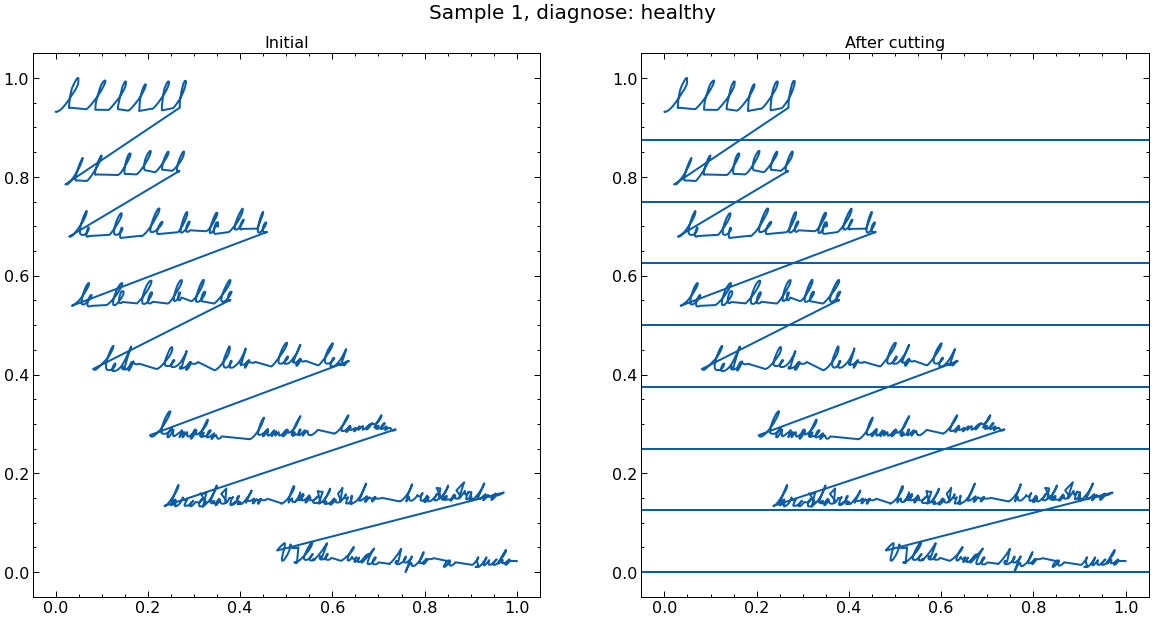

In [337]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].plot(coords[0][:, 0], coords[0][:, 1])
ax[1].plot(coords[0][:, 0], coords[0][:, 1])

for i in range(8):
    ax[1].axhline(i*0.125)

ax[0].set_title('Initial')
ax[1].set_title('After cutting')

fig.suptitle(f'Sample 1, diagnose: {"dysgraphia" if labels[0] == 1 else "healthy" }', fontsize=20, y=0.95)
fig.savefig('graphs/cutting')

## Cut image in 8 slices

In [349]:
def cut(arr):
    cutting = arr[:, 1] * 8
    cutting = cutting - 0.0001
    cutting = np.trunc(cutting)
    cuts = [[] for _ in range(8) ]

    for i, cut in enumerate(cutting):
        cuts[int(cut)].append(arr[i, :])

    cuts = [np.vstack(cut) for cut in cuts]
    cuts = reversed(cuts)
    new_cuts = []
    for i, c in enumerate(cuts):
        new_c = np.zeros(c.shape)
        new_c[:, 1] = minmax_scale(c[:, 1] + (i/8))
        new_c[:, 0] = minmax_scale(c[:, 0] + (i))
        new_c[:, 2] = c[:, 2]
        new_cuts.append(new_c)
        
    return new_cuts

def mix(data):
    data, label, user_id = data
    return [Writing(data=d, label=label, type_=i, user_id=user_id) for i, d in enumerate(data)]
    
cutted = [cut(i) for i in coords]
data = [mix(m) for m in zip(cutted, labels, user_ids)]
data = [j for i in data for j in i]
#data = [(minmax_scale(x, axis=0), y, k) for x, y, k in data]

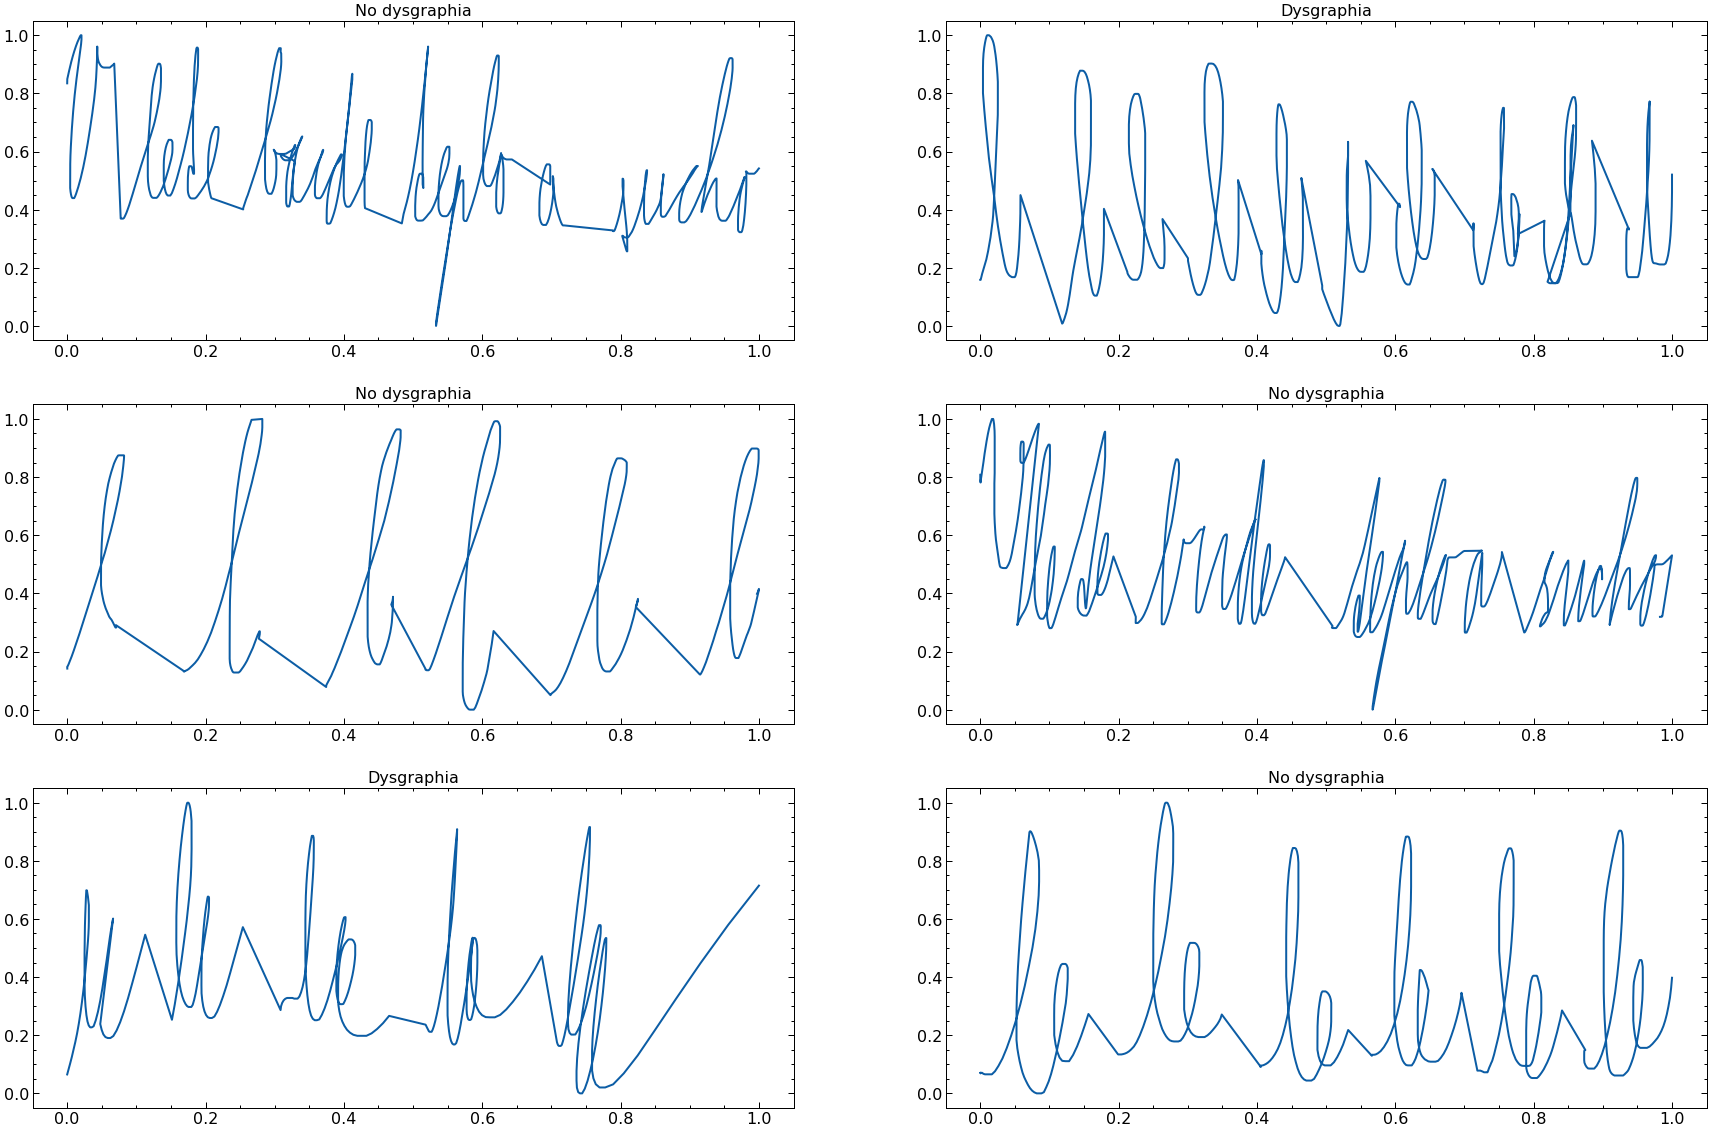

In [36]:
fig = plt.figure(figsize=(30, 20))

for i, d in enumerate(np.random.choice(data, 6)):
    ax = fig.add_subplot(3, 2, i+1)
    ax.plot(d.data[:, 0], d.data[:, 1])
    ax.set_title(f'{"Dysgraphia" if d.label == 1 else "No dysgraphia"}')
# remove outliers
plt.savefig('graphs/writings')

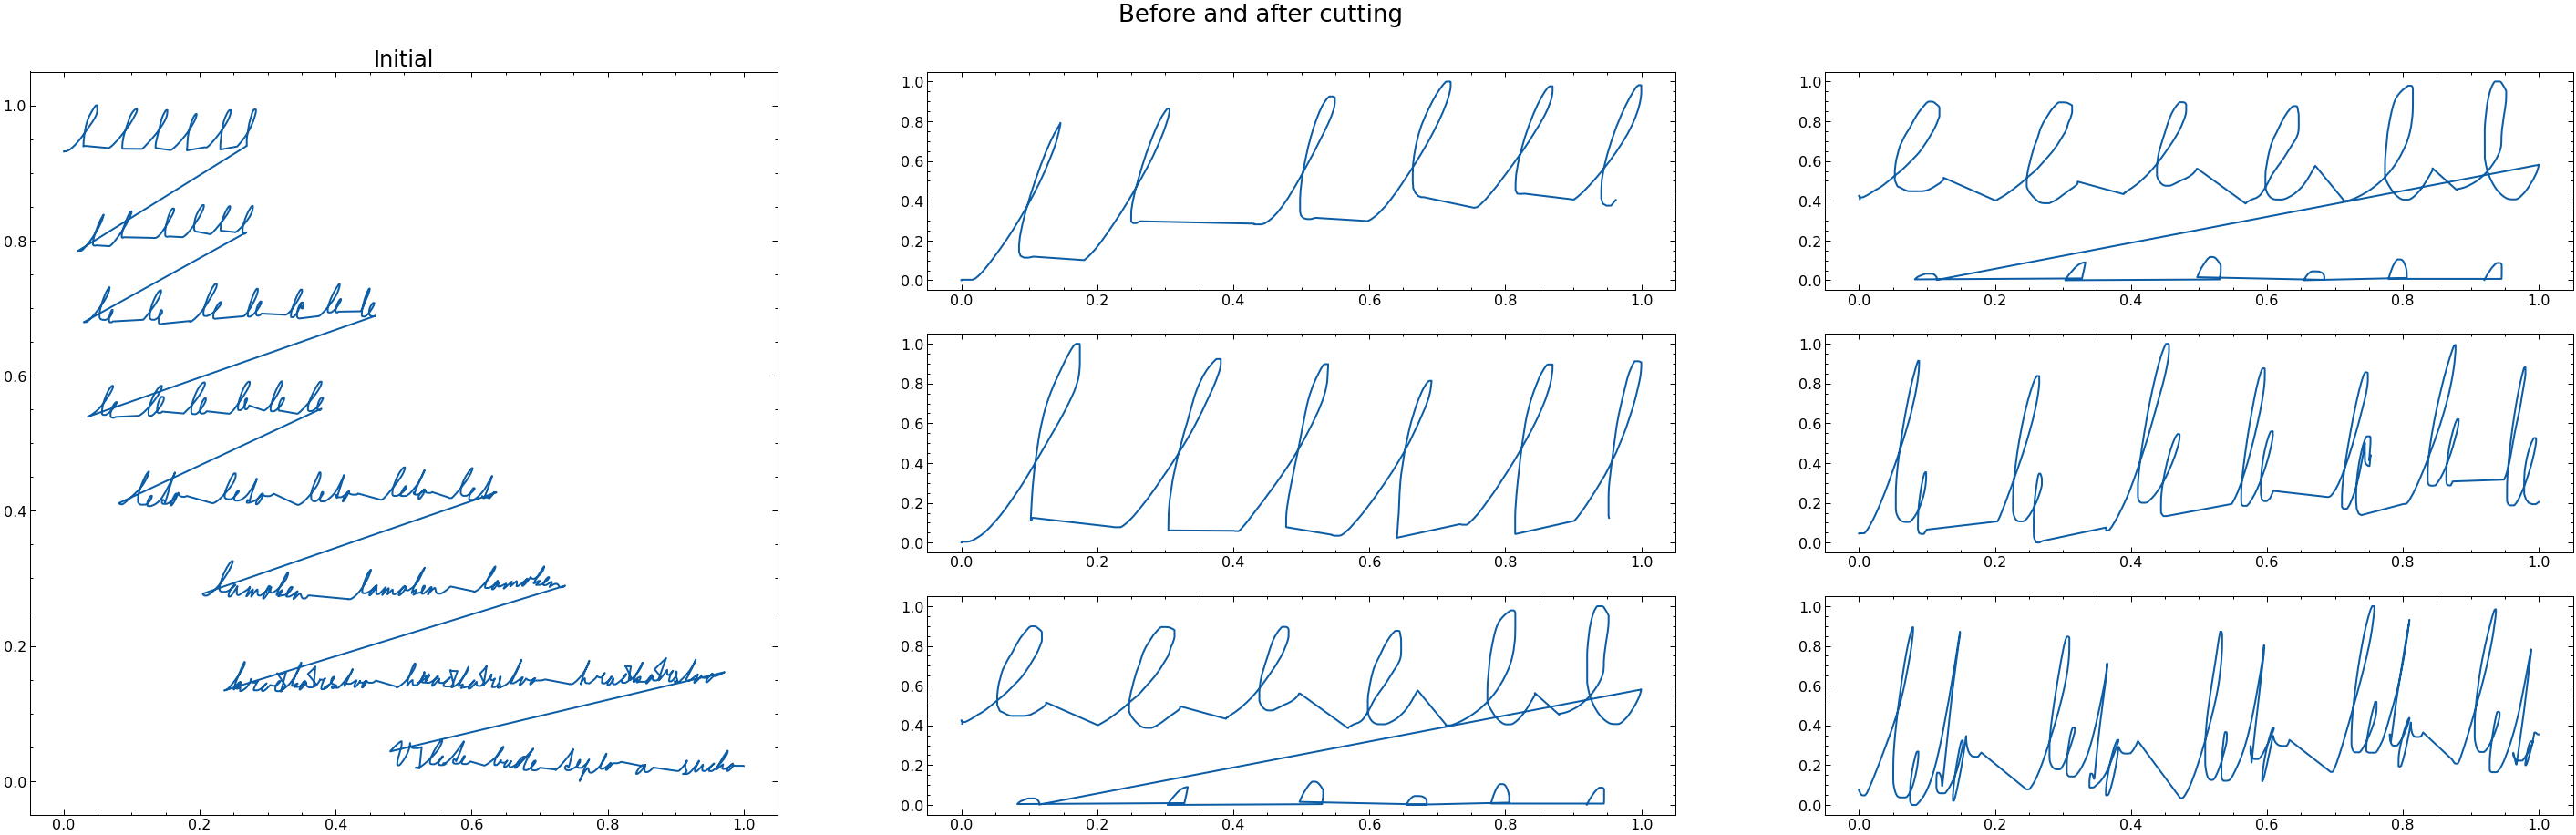

In [362]:
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(50, 15))
gs = GridSpec(3, 3, figure=fig)

ax = [ fig.add_subplot(gs[:, 0]) ]

for i in range(3):
    for j in range(2):
        ax.append(fig.add_subplot(gs[i, j+1]))


ax[0].plot(coords[0][:, 0], coords[0][:, 1])
ax[0].set_title('Initial', fontsize=24)


for i, d in enumerate(np.random.choice(data[:9], 6)):
    ax[i+1].plot(d.data[:, 0], d.data[:, 1])
    #ax[i+1].set_title(f'{"Dysgraphia" if d.label == 1 else "No dysgraphia"}')


fig.suptitle(f'Before and after cutting', fontsize=26, y=0.95)
fig.savefig('graphs/cutting')

In [8]:
with open('data.pickle', 'wb') as f:
    pickle.dump(data, f)

In [39]:
for d in tqdm(data):
    d.get_bezier_features()

with open('data.pickle', 'wb') as f:
    pickle.dump(data, f)

100%|██████████| 960/960 [06:24<00:00,  2.50it/s]


In [5]:
with open('data.pickle', 'rb') as f:
    data = pickle.load(f)

sample_trajectories = data[3].split_with_mpd()

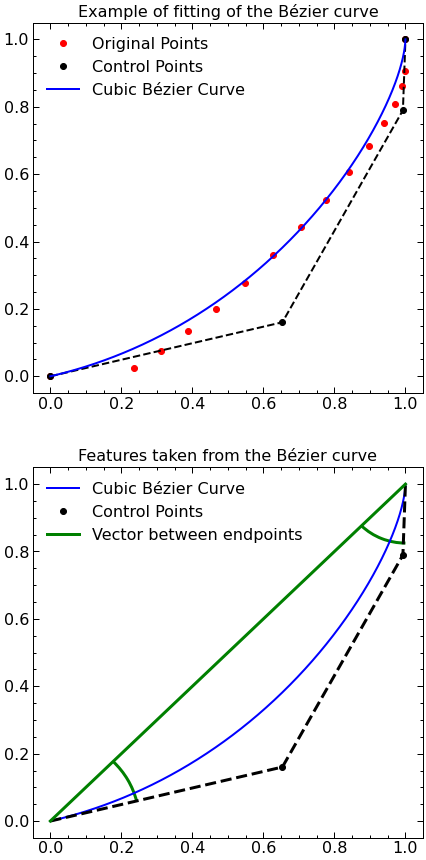

In [8]:
from sklearn.preprocessing import minmax_scale
import matplotlib.pyplot as plt
from bezier import *
from matplotlib.patches import Arc

fig, ax = plt.subplots(2, 1, figsize=(7, 15))

xpoints = minmax_scale(sample_trajectories[7][:, 0], (0, 1))
ypoints = minmax_scale(sample_trajectories[7][:, 1], (0, 1))

# Plot the original points
ax[0].plot(xpoints, ypoints, "ro",label='Original Points')
# Get the Bezier parameters based on a degree.
data = get_bezier_parameters(xpoints, ypoints, degree=3)
x_val = [x[0] for x in data]
y_val = [x[1] for x in data]
#print(data)
# Plot the control points
ax[0].plot(x_val,y_val,'ko', label='Control Points')
ax[0].plot(x_val,y_val,'k--')

# Plot the resulting Bezier curve
xvals, yvals = bezier_curve(data, nTimes=1000)
ax[0].plot(xvals, yvals, 'b-', label='Cubic Bézier Curve')

#ax.set_xticklabels([])
#ax.set_yticklabels([])

ax[0].set_title('Example of fitting of the Bézier curve')
ax[0].legend()


def angle_between(p1, p2):
    ang1 = np.arctan2(*p1[::-1])
    ang2 = np.arctan2(*p2[::-1])
    return np.rad2deg((ang1 - ang2) % (2 * np.pi))

ax[1].plot(xvals, yvals, 'b-', label='Cubic Bézier Curve')
ax[1].plot(x_val[1:-1],y_val[1:-1],'ko', label='Control Points', linewidth=3)
ax[1].plot(x_val,y_val,'k--', linewidth=3)
ax[1].plot([x_val[0], x_val[-1]], [y_val[0], y_val[-1]], 'g-', label='Vector between endpoints', linewidth=3)


ang = 360 - angle_between([x_val[0], y_val[0]], [x_val[1], y_val[1]])
theta2 = 360 - angle_between([x_val[0], y_val[0]], [x_val[-1], y_val[-1]]) - ang 
ax[1].add_patch(Arc((x_val[0], y_val[0]), 50/100, 50/100, angle=ang, theta1=0, theta2=theta2, color='green', linewidth='3'))

theta1 = angle_between([x_val[-2], y_val[-2]], [x_val[-1], y_val[-1]])
theta2 = angle_between([x_val[0], y_val[0]], [x_val[-1], y_val[-1]])
ax[1].add_patch(Arc((x_val[-1], y_val[-1]), 35/100, 35/100, angle=180-theta2-theta1, theta1=theta1, theta2=-theta2+theta1, color='green', linewidth='3'))

ax[1].set_xlim(-0.05, 1.05)
ax[1].set_ylim(-0.05, 1.05)

#ax.set_xticklabels([])
#ax.set_yticklabels([])

ax[1].legend()
ax[1].set_title('Features taken from the Bézier curve')

fig.savefig('graphs/fitting')

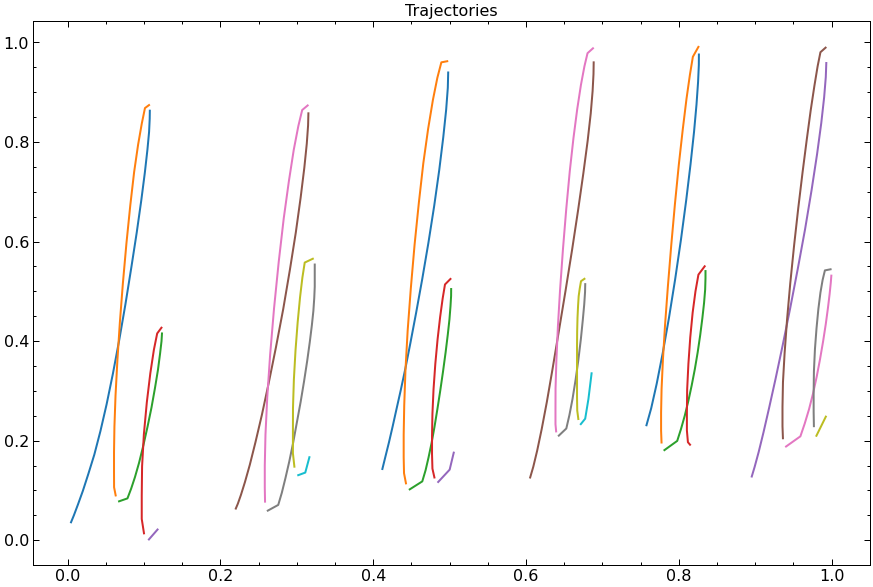

In [28]:
from matplotlib.collections import LineCollection
from matplotlib.colors import TABLEAU_COLORS

fig, ax = plt.subplots(figsize=(15, 10))
ax.add_collection(LineCollection([t[:, 0:2] for t in sample_trajectories], colors=list(TABLEAU_COLORS.values())))
ax.set_title('Trajectories')
ax.autoscale()
fig.savefig('graphs/trajectories')